See other document for deliverables. Also wish to run code, make sure to switch runtime type

In [2]:
# imports and connect to google drive
from google.colab import drive
drive.mount('/content/drive')

%matplotlib inline
import scipy as sp
import numpy as np
import scipy.io as spio
import tensorflow as tf
import matplotlib.pyplot as plt
import time
import math
from keras import backend as K
from random import randint, uniform, gauss
from math import sqrt
from tqdm import tqdm_notebook, tqdm, tnrange
from pathlib import Path
from pylab import figure, cm
from tensorflow import keras
from matplotlib.colors import LogNorm
from tensorflow.python.client import device_lib
from sklearn.model_selection import train_test_split

Mounted at /content/drive


dict_keys(['__header__', '__version__', '__globals__', 'X', 'Y'])
X shape is  (10000, 64, 64)
Y shape is  (10000, 64, 64)


Text(0.5, 1.0, 'Initial Guess')

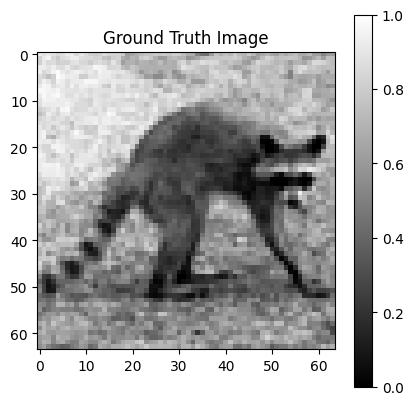

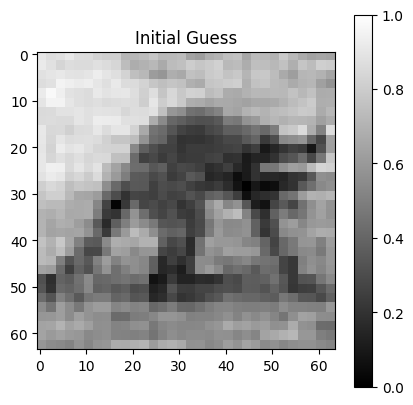

In [3]:
# load matlab matrix
mat_dict = spio.loadmat("/content/drive/MyDrive/ENGS117/Project4_Data.mat")
print(mat_dict.keys())

X = mat_dict["X"]
Y = mat_dict["Y"]
print('X shape is ', X.shape)
print('Y shape is ', Y.shape)

# plot the image with index 99 to visualize the problem
# plot ground truth
imageIndex = 99
im1 = plt.matshow(Y[imageIndex,:,:], cmap=cm.gray, vmin = 0.0, vmax = 1)
cbar1 = plt.colorbar(im1)
plt.gca().xaxis.tick_bottom()
plt.title('Ground Truth Image')

# plot initial guess
im1 = plt.matshow(X[imageIndex,:,:], cmap=cm.gray, vmin = 0.0, vmax = 1)
cbar1 = plt.colorbar(im1)
plt.gca().xaxis.tick_bottom()
plt.title('Initial Guess')

In [4]:
# split into training, testing, and validation (80/10/10 split)
X_train, X_temp, Y_train, Y_temp = train_test_split(X, Y, test_size=0.2, random_state=42)
X_val, X_test, Y_val, Y_test = train_test_split(X_temp, Y_temp, test_size=0.5, random_state=42)

In [5]:
# Define the U-Net model
def unet_model(input_shape):
    inputs = keras.layers.Input(input_shape)

    # Encoder
    conv1 = keras.layers.Conv2D(64, 3, activation='relu', padding='same')(inputs)
    pool1 = keras.layers.MaxPooling2D(pool_size=(2, 2))(conv1)
    conv2 = keras.layers.Conv2D(128, 3, activation='relu', padding='same')(pool1)
    pool2 = keras.layers.MaxPooling2D(pool_size=(2, 2))(conv2)

    # Bottleneck
    conv3 = keras.layers.Conv2D(256, 3, activation='relu', padding='same')(pool2)

    # Decoder
    up4 = keras.layers.UpSampling2D((2, 2))(conv3)
    concat4 = keras.layers.Concatenate()([conv2, up4])
    conv4 = keras.layers.Conv2D(128, 3, activation='relu', padding='same')(concat4)
    up5 = keras.layers.UpSampling2D((2, 2))(conv4)
    concat5 = keras.layers.Concatenate()([conv1, up5])
    conv5 = keras.layers.Conv2D(64, 3, activation='relu', padding='same')(concat5)

    outputs = keras.layers.Conv2D(1, 1, activation='sigmoid')(conv5)

    return keras.models.Model(inputs, outputs)

In [9]:
# Prepare data and create the model
input_shape = (64, 64, 1)
model = unet_model(input_shape)
# Compile the model, loss function chosen is MSE
model.compile(optimizer='adam', loss='mean_squared_error')

# Loss function plateaus at this epoch
epochs_num = 20
model.fit(X_train, Y_train, epochs=epochs_num, validation_data=(X_val, Y_val))
test_mse = model.evaluate(X_test, Y_test)
print("Test MSE:", test_mse)

Epoch 1/20
250/250 [==============================] - 12s 43ms/step - loss: 0.0071 - val_loss: 0.0037
Epoch 2/20
250/250 [==============================] - 10s 41ms/step - loss: 0.0038 - val_loss: 0.0035
Epoch 3/20
250/250 [==============================] - 11s 42ms/step - loss: 0.0036 - val_loss: 0.0034
Epoch 4/20
250/250 [==============================] - 11s 42ms/step - loss: 0.0035 - val_loss: 0.0034
Epoch 5/20
250/250 [==============================] - 10s 41ms/step - loss: 0.0035 - val_loss: 0.0033
Epoch 6/20
250/250 [==============================] - 10s 41ms/step - loss: 0.0034 - val_loss: 0.0033
Epoch 7/20
250/250 [==============================] - 10s 41ms/step - loss: 0.0034 - val_loss: 0.0033
Epoch 8/20
250/250 [==============================] - 10s 42ms/step - loss: 0.0034 - val_loss: 0.0032
Epoch 9/20
250/250 [==============================] - 10s 41ms/step - loss: 0.0034 - val_loss: 0.0032
Epoch 10/20
250/250 [==============================] - 10s 41ms/step - loss: 0.003

In [10]:
model.summary()

Model: "model_3"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_4 (InputLayer)        [(None, 64, 64, 1)]          0         []                            
                                                                                                  
 conv2d_18 (Conv2D)          (None, 64, 64, 64)           640       ['input_4[0][0]']             
                                                                                                  
 max_pooling2d_6 (MaxPoolin  (None, 32, 32, 64)           0         ['conv2d_18[0][0]']           
 g2D)                                                                                             
                                                                                                  
 conv2d_19 (Conv2D)          (None, 32, 32, 128)          73856     ['max_pooling2d_6[0][0]'

1/1 [==============================] - 0s 20ms/step


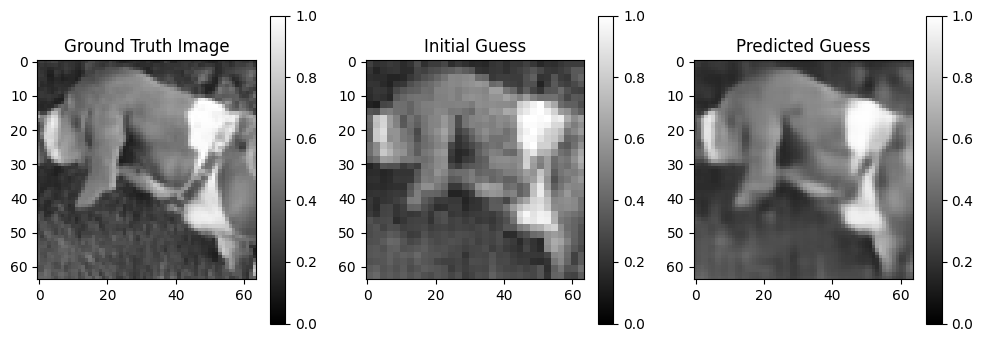

In [45]:
# plot the predicted image of a random initial guess in X_test
randIndex = randint(0, 999)
predictedImage = model.predict(X_test[randIndex:randIndex+1])

plt.figure(figsize=(12, 4))

# Plot the Ground Truth Image
plt.subplot(131)
im1 = plt.imshow(Y_test[randIndex, :, :], cmap=cm.gray, vmin=0.0, vmax=1)
cbar1 = plt.colorbar(im1)
plt.gca().xaxis.tick_bottom()
plt.title(r'Ground Truth Image')

# Plot the Initial Guess
plt.subplot(132)
im2 = plt.imshow(X_test[randIndex, :, :], cmap=cm.gray, vmin=0.0, vmax=1)
cbar2 = plt.colorbar(im2)
plt.gca().xaxis.tick_bottom()
plt.title(r'Initial Guess')

# Plot the Predicted Image
plt.subplot(133)
im3 = plt.imshow(predictedImage[0], cmap=cm.gray, vmin=0.0, vmax=1)
cbar3 = plt.colorbar(im3)
plt.gca().xaxis.tick_bottom()
plt.title(r'Predicted Guess')

plt.show()